# Определение стоимости автомобилей

Компания по продаже б/у автомобилей разрабатывает новую функцию своего приложения. В нём можно автоматически определить рыночную стоимость своего автомобиля.

**Цель:** Необходимо построить модель для определения стоимости автомобилей на основании технических характеристик, комплектаций других данных.

Что необходимо учитывать при выборе наилучшей модели:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**

- `Price` — цена (евро)

## Подготовка данных

### Загрузка данных и общий обзор

In [ ]:
# импортируем необходимые библиотеки
# pandas для работы с таблицами
import pandas as pd
# numpy для работы с массивами
import numpy as np
# будет использовать библиотеку seaborn для визуализации
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# загрузим данные из файла
data = pd.read_csv('/datasets/autos.csv')
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [ ]:
data['DateCrawled'].unique()

array(['2016-03-24 11:52:17', '2016-03-24 10:58:45',
       '2016-03-14 12:52:21', ..., '2016-03-21 09:50:58',
       '2016-03-14 17:48:27', '2016-03-19 18:57:12'], dtype=object)

In [ ]:
print(data['DateCrawled'].min())
print(data['DateCrawled'].max())

2016-03-05 14:06:22
2016-04-07 14:36:58


In [ ]:
# с помощью метода .info() посмотрим на структуру данных: кол-во строк, столбцов, тип данных и наличие пропущенных значений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

- видим, что в данных есть пропуски;
- в таблице есть как числовые, так и категориальные признаки;
- некоторые признаки не помогут нам в качественном обучении модели, например, такие признаки как `PostalCode` и `NumberOfPictures` не несут никакой полезной информации для модели: ни от почтового индекса, ни от кол-во картинок продаваемого имущества. Конечно, по индексу в теории можно определить локацию продавца и оценить адекватность стоимости машины для того или иного региона, но у нас недостаточно данных для такого анализа.
- `DateCrawled` тоже не несет для нас полезной информации;
- `LastSeen` может косвено может нам говорить о даче продажи, но никак не о стоимости автомобиля.

In [ ]:
# избавимся от неинформативных признаков
data = data.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen'], axis=1)

#### Корреляция признаков

<AxesSubplot:>

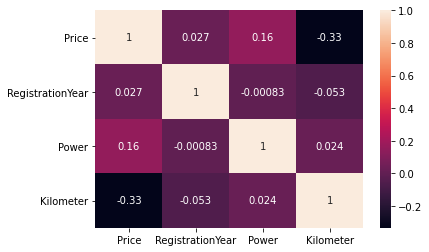

In [ ]:
# посмотрим корреляцю числовых признаков и целевого признака
numeric_cols = list(data.select_dtypes(include='int64').columns)
# однако столбец с указанием месяца регистрации авто удалим из матрицы корреляции, т.к. между месяцами упорядоченности нет
numeric_cols.remove('RegistrationMonth')
corr_matrix = data.loc[:, numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True)

Особой корреляции нет.

#### Распределение числовых признаков

##### Дата регистрации автомобиля

Для данных по году регистрации график строить не будем, так при таком кол-ве значений не очень удобно работать по визуалиции.

In [ ]:
# посмотрим на квантили
data.RegistrationYear.describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
5%         1992.000000
10%        1995.000000
15%        1997.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
95%        2016.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Как мы видим, менее 5% продаваемых авто зарегестрированы ранее 1992 г. 1000 г - явный выброс. Авто, зарегестрированные в период с 1910 по 1980 могут быть правдой, но это скорее всего какие-нибудь выставочные модели, которые не продают как средство передвижения и признаки для определения стоимости раритетного авто, думаю, были бы другими, поэтому, данные до 1990 г. целесообразно удалить, чтобы облегчить работу модели. 

Помимо этого также видим, что после 95% квантиля у нас есть значения между 2016 г и 9999 г, все, что больше ~~2022~~ 2016 примем за выброс, т.к. данные об объявлениях выгружены в 2016 г.

In [ ]:
data = data[(data['RegistrationYear']>=1990)&(data['RegistrationYear']<=2016)]

Теперь данные столбца выглядят вполне реалистично.

##### Пробег

In [ ]:
# также посмотрим на квантили по пробегу
data.Kilometer.describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])

count    330170.000000
mean     128721.991701
std       37233.771646
min        5000.000000
5%        40000.000000
10%       70000.000000
15%       90000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
95%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Так как все значения кратны 5 000 км, можем сделать вывод о том, что это округленные значения. О том, насколько они адекватны судить сложно, потому что важно учитывать возраст автомобиля, честность автовладельца и манеру его вождения (может использует машину только по выходным на дачу скататься).
Поэтому данные столбца оставим как есть.

##### Мощность двигателя автомобиля

In [ ]:
# также посмотрим на квантили по мощности двигателя
data.Power.describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])

count    330170.000000
mean        111.788915
std         184.344033
min           0.000000
5%            0.000000
10%           0.000000
15%          55.000000
25%          71.000000
50%         105.000000
75%         143.000000
95%         218.000000
max       20000.000000
Name: Power, dtype: float64

Нулевые значения мощности - явно выбросы, также сложно среди +- современных моделей увидеть автомобили с мощностью двигателя менее 60-65 л.с.

Теперь о значениях выше 95% квантиля. Конечно, бывают авто и с 2 000 л.с., но у нас в списке представленных брендов нет ни Бугатти, ни Пининфарины, ни Лотуса, поэтому все, что больше 1 000 л.с. будем считать за выбросы. 

In [ ]:
f"Количество автомобилей с аномальными значениями в мощности двигателя: {len(data.loc[(data['Power'] > 1000) | (data['Power'] <= 65)])}"

'Количество автомобилей с аномальными значениями в мощности двигателя: 75098'

Данных достаточно много, поэтому удалять их не будем, заполним аномальные значения медианным значением объектов той же модели.

<AxesSubplot:xlabel='Power', ylabel='Count'>

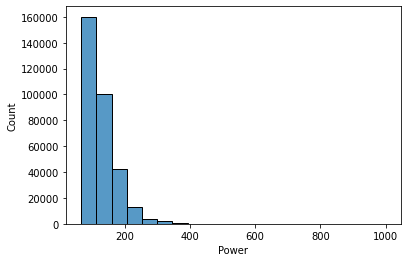

In [ ]:
data.loc[(data['Power'] > 1000) | (data['Power'] <= 65), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
data = data.loc[~data['Power'].isna()]
data['Power'] = data['Power'].astype('int64')
sns.histplot(data['Power'], bins=20)

##### Стоимость автомобиля

<AxesSubplot:xlabel='Price', ylabel='Count'>

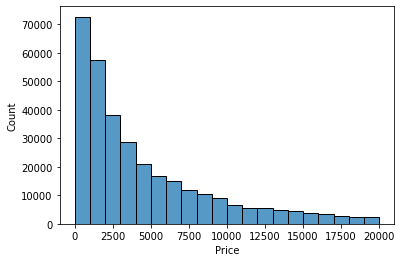

In [ ]:
# посмотрим на распределение стоимости автомобилей
sns.histplot(data['Price'], bins=20)

In [ ]:
# посмотрим, какие бренды представлены в таблице
data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'suzuki', 'daihatsu',
       'saab', 'chrysler', 'jaguar', 'daewoo', 'porsche', 'rover',
       'land_rover', 'lada', 'trabant'], dtype=object)

Видим справа довольно длинный хвост, но очень дорогие авто удалять не будем, там нет ярко выраженных пиков, поэтому в принципе похоже на правду. А вот нулевые значения - явные выбросы. Значения целевого признака, коим является `Price`, мы никак восстанавливать по остальным данным таблицы не будем. Вердикт - все, что дешевле 250 евро, удаляем.

In [ ]:
data.Price.describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])

count    323137.000000
mean       4527.002655
std        4549.419820
min           0.000000
5%          250.000000
10%         500.000000
15%         700.000000
25%        1150.000000
50%        2850.000000
75%        6500.000000
95%       14850.000000
max       20000.000000
Name: Price, dtype: float64

In [ ]:
invalid_price = data[(data['Price'] < 250)]
invalid_price.shape

(15974, 12)

In [ ]:
data.drop(invalid_price.index, inplace=True)

In [ ]:
data.shape

(307163, 12)

Уже видим, что есть аномальные значения в столбцах c годом регистрации автомобиля и мощностью двигателя.

### Еще предобработка данных

#### Удаляем дубликаты

In [ ]:
# посмотрим на кол-во дубликатов
print('Количество дубликатов:', sum(data.duplicated()))

Количество дубликатов: 11102


Дубликатов много, на качество модели они не повлияют, поэтому от них можно избавиться.

In [ ]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

#### Пропуски в категориальных признаках

In [ ]:
# посмотрим, в каких столбцах пропуски и сколько их
data.isna().sum()

Price                    0
VehicleType          14568
RegistrationYear         0
Gearbox              10469
Power                    0
Model                 8055
Kilometer                0
RegistrationMonth        0
FuelType             18058
Brand                    0
NotRepaired          49293
DateCreated              0
dtype: int64

Пропуски в основном в категориальных данных. Посмотрим, что из этого мы сможем заполнить по данным. имеющимся в таблице.
Столбец с данными о модели авто мы не сможем восстановить, поэтому их придется удалить.
Пропуски в столбце по типу коробки, типу топлива и типу автомобильного кузова можем заполнить наиболее часто встречающимися данными в этом столбце при группировке по модели.
Данные в столбце с информацией о ремонте автомобиля мы восстановить не сможем, поэтому заполним пропуски значением `unknown`.

##### Бит или не бит

In [ ]:
# заполним данные в столбце с информацией о ремонте автомобиля
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')

In [ ]:
# уберем из таблицы объекты, где модель автомобиля неизвестна
data = data.loc[~data['Model'].isna()]

##### Восстановление данных по модели авто

In [ ]:
data.groupby('Model')['Gearbox'].value_counts().idxmax()

('golf', 'manual')

In [ ]:
# заполним данные с типом кузова, коробки и топлива 
data['VehicleType'] = data['VehicleType'].fillna(data
                                                  .groupby('Model')['VehicleType']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )
data['Gearbox'] = data['Gearbox'].fillna(data
                                         .groupby('Model')['Gearbox']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )
data['FuelType'] = data['FuelType'].fillna(data
                                           .groupby('Model')['FuelType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

<div class='alert alert-success'> ✔️Крутой способ заполнения!
</div>


##### На чем едет? или неявные дубликаты

При первичном осмотре мой лингвистический взгляд упал по два слова в столбце `FuelType` - "gasoline" и "petrol". Взглянем поподробнее

In [ ]:
# найдем уникальные значения
data['FuelType'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Petrol и Gasoline означают одно и то же - бензин, разница между ними только в том, что Petrol - наименование, распространенное в Великобритании, а Gasoline - в США. Соответственно, можем это, скорее всего, рассматривать как неявный дубликат. Так как у нас нет подробной информации о том, где именно автомобиль продается (локация), то рассматриваем как дубликаты.

lpg и cng - разновидности газового топлива, но их в одну категорию выделять не будем, т.к. вдруг все-таки тип используемого газа может как-то влиять на стоимость авто.

In [ ]:
data.loc[(data['FuelType'] == 'gasoline'), 'FuelType'] = 'petrol'

<div class='alert alert-success'> ✔️Очень меткое замечание!
</div>


##### Даты

От даты регистрации объявления на платоформе в теории может зависеть цена, т.к. от года к году цена на все товары меняются (кризисы, инфляция и т.д.), машиины не исключение. Однако не факт, что эти объявления не обновлялись.
Выбросов по дате публикации объявлений нет - ранее мы выдели, что в таблицу вошли объявления о продаже автомобилей с 2014 по 2016 гг.

In [ ]:
# переведем дату в читаемый формат
data['DateCreated'] = pd.to_datetime(data['DateCreated'])

In [ ]:
# сделаем отдельно столбцы с годом и месяцев регистрации объявления, остальные данные по дате нам в принципе неинтересны
data['DateCreated_month'] = pd.DatetimeIndex(data['DateCreated']).month
data['DateCreated_year'] = pd.DatetimeIndex(data['DateCreated']).year

In [ ]:
# удалим теперь уже ненужный столбец
data = data.drop(['DateCreated'], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288006 entries, 0 to 296060
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              288006 non-null  int64 
 1   VehicleType        288006 non-null  object
 2   RegistrationYear   288006 non-null  int64 
 3   Gearbox            288006 non-null  object
 4   Power              288006 non-null  int64 
 5   Model              288006 non-null  object
 6   Kilometer          288006 non-null  int64 
 7   RegistrationMonth  288006 non-null  int64 
 8   FuelType           288006 non-null  object
 9   Brand              288006 non-null  object
 10  NotRepaired        288006 non-null  object
 11  DateCreated_month  288006 non-null  int64 
 12  DateCreated_year   288006 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 30.8+ MB


In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288006 entries, 0 to 288005
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              288006 non-null  int64 
 1   VehicleType        288006 non-null  object
 2   RegistrationYear   288006 non-null  int64 
 3   Gearbox            288006 non-null  object
 4   Power              288006 non-null  int64 
 5   Model              288006 non-null  object
 6   Kilometer          288006 non-null  int64 
 7   RegistrationMonth  288006 non-null  int64 
 8   FuelType           288006 non-null  object
 9   Brand              288006 non-null  object
 10  NotRepaired        288006 non-null  object
 11  DateCreated_month  288006 non-null  int64 
 12  DateCreated_year   288006 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 28.6+ MB


In [ ]:
data.VehicleType.value_counts()

sedan          84693
small          71928
wagon          59725
bus            28159
convertible    17603
coupe          13161
suv            10429
other           2308
Name: VehicleType, dtype: int64

In [ ]:
data.Gearbox.value_counts()

manual    230549
auto       57457
Name: Gearbox, dtype: int64

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
data.Model.value_counts(ascending=True)

range_rover_evoque        1
rangerover                3
200                       3
kalina                    5
samara                    8
i3                        8
gl                       11
amarok                   12
q3                       13
kappa                    13
materia                  18
charade                  20
9000                     20
musa                     22
b_max                    25
delta                    28
lodgy                    32
145                      34
terios                   34
croma                    38
v60                      39
kaefer                   40
move                     42
90                       44
911                      46
lybra                    46
range_rover_sport        53
nubira                   55
g_klasse                 58
crossfire                58
cx_reihe                 61
glk                      61
defender                 62
range_rover              64
lanos                    65
discovery           

Ну давайте в таком случае удалим все модели, для которых число  вхождений менее 100.

In [ ]:
models_to_delete = ['range_rover_evoque', '200', 'rangerover', 'kalina', 'samara', 'i3', 'gl', 'amarok', 'q3', 'kappa', 'materia'
                    'charade', '9000', 'musa,b_max', 'delta,lodgy', 'terios', 'croma', 'v60', 'kaefer', 'move', 'lybra', '911',
                    'range_rover_sport', 'nubira', 'crossfire', 'g_klasse', 'cx_reihe', 'glk', 'defender', 'range_rover', 'lanos', 
                    'discovery', 'mii', 'citigo', 'navara', 'kalos', 'q5', 'wrangler', '900', 'r19', 'juke', 'exeo', 'antara']


In [ ]:
data['Model_new'] = data['Model'].apply(lambda x: 'other' if x in models_to_delete else x)

In [ ]:
data = data.drop('Model', axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288006 entries, 0 to 288005
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              288006 non-null  int64 
 1   VehicleType        288006 non-null  object
 2   RegistrationYear   288006 non-null  int64 
 3   Gearbox            288006 non-null  object
 4   Power              288006 non-null  int64 
 5   Kilometer          288006 non-null  int64 
 6   RegistrationMonth  288006 non-null  int64 
 7   FuelType           288006 non-null  object
 8   Brand              288006 non-null  object
 9   NotRepaired        288006 non-null  object
 10  DateCreated_month  288006 non-null  int64 
 11  DateCreated_year   288006 non-null  int64 
 12  Model_new          288006 non-null  object
dtypes: int64(7), object(6)
memory usage: 28.6+ MB


In [ ]:
data.Brand.value_counts()

volkswagen       61878
opel             31870
bmw              31000
mercedes_benz    26885
audi             24918
ford             20358
renault          14515
peugeot           9063
fiat              7554
seat              5800
skoda             4936
mazda             4690
smart             4580
citroen           4214
nissan            4130
toyota            4086
hyundai           3076
mini              2868
volvo             2707
mitsubishi        2495
honda             2332
kia               2112
suzuki            1889
alfa_romeo        1850
chevrolet         1338
chrysler          1169
dacia              814
daihatsu           630
subaru             629
jeep               543
porsche            503
land_rover         453
saab               438
daewoo             423
jaguar             417
lancia             339
rover              332
lada               156
trabant             16
Name: Brand, dtype: int64

### Прямое кодирование категориальных признаков

Закодируем категориальные признаки с помощью прямого кодирования в числовые, т.к. их модели понимают лучше.

In [ ]:
# выделим категориальные признаки
cat_cols = ['VehicleType', 'Gearbox', 'Model_new', 'FuelType', 'Brand', 'NotRepaired']

In [ ]:
encoder = OneHotEncoder(sparse=False, drop='first')
cat_cols_encoded = encoder.fit_transform(data[cat_cols])

In [ ]:
#cat_cols_encoded = pd.DataFrame.sparse.from_spmatrix(cat_cols_encoded)
cat_cols_encoded = pd.DataFrame(cat_cols_encoded, columns=encoder.get_feature_names(cat_cols))

In [ ]:
data_encoded = data.join(cat_cols_encoded)

In [ ]:
data_encoded = data_encoded.drop(['VehicleType', 'Gearbox', 'Model_new', 'FuelType', 'Brand', 'NotRepaired'], axis=1)

In [ ]:
data_encoded.isna().sum()

Price                      0
RegistrationYear           0
Power                      0
Kilometer                  0
RegistrationMonth          0
DateCreated_month          0
DateCreated_year           0
VehicleType_convertible    0
VehicleType_coupe          0
VehicleType_other          0
VehicleType_sedan          0
VehicleType_small          0
VehicleType_suv            0
VehicleType_wagon          0
Gearbox_manual             0
Model_new_145              0
Model_new_147              0
Model_new_156              0
Model_new_159              0
Model_new_1_reihe          0
Model_new_1er              0
Model_new_2_reihe          0
Model_new_300c             0
Model_new_3_reihe          0
Model_new_3er              0
Model_new_4_reihe          0
Model_new_500              0
Model_new_5_reihe          0
Model_new_5er              0
Model_new_6_reihe          0
Model_new_6er              0
Model_new_7er              0
Model_new_80               0
Model_new_850              0
Model_new_90  

### Делим данные на выборки и масштабируем признаки

In [ ]:
# сначала делим данные на features (x) и target (y)
X = data_encoded.drop('Price', axis=1)
Y = data_encoded['Price']
# затем на обучающую (75%) и тестовую выборки (25%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

In [ ]:
f"Размер обучающей выборки: {X_train.shape}"

'Размер обучающей выборки: (216004, 264)'

In [ ]:
f"Размер тестовой выборки: {X_test.shape}"

'Размер тестовой выборки: (72002, 264)'

In [ ]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
data_encoded.shape

(288006, 265)

In [ ]:
288006/354369 * 100

81.2729104408117

Получается, что в процессе предобработки мы удалили 19% данных.

### Выводы

Данные загружены и проанализированы:
- удалены дубликаты;
- удалены пропущенные значения, которые не удалось заполнить по данным в таблице;
- некоторые пропущенные значения заполнены на основе других данных таблицы (тип топлива, тип коробки и тип кузова заполнены медианным значением по модели автомобиля);
- неинформативные для исследования признаки удалены: `NumberOfPictures`, `PostalCode`, `DateCrawled`, `LastSeen`;
- удалены или заполнены аномальные значения;
- найден один неявный дубликат - разные наименования бензина;
- категориальные признаки закодированы в численные;
- данные разделены на обучающую и тестовую выборки;
- признаки масштабированы.

Данные преобразованы и готовы к дальнейшему ходу исследования.

## Обучение моделей

Для оценки качества разных моделей будем использовать метрику RMSE. Создадим scorer, который в дальнейшем будем использовать для скоринга моделей, за основу как раз возьмем метрику RMSE.

In [ ]:
def RMSE(target, predict):
    RMSE = mean_squared_error(target, predict) ** 0.5
    return RMSE

scorer = make_scorer(RMSE, greater_is_better=False)

In [ ]:
# Стратегия кросс-валидации для подбора параметров:
cross_val_param = ShuffleSplit(n_splits=3, test_size=0.2, random_state=12345)

### Константная модель

Для начала создадим константную модель, чтобы потом на ее основе проверять модели на адекватность.

In [ ]:
# создадим константную модель, которая в качестве предсказаний выдает медианное значение стоимости автомобиля
constant_mdl_preds = pd.Series(data=Y_train.median(), index=Y_train.index, dtype='int64')
constant_mdl_RMSE = RMSE(Y_train, constant_mdl_preds)
f"RMSE для константной модели: {round(constant_mdl_RMSE, 2)}"

'RMSE для константной модели: 4876.69'

### Линейная регрессия

In [ ]:
LR_mdl = LinearRegression()

In [ ]:
%%time
LR_mdl.fit(X_train, Y_train)

CPU times: user 13.3 s, sys: 2.97 s, total: 16.2 s
Wall time: 16.2 s


LinearRegression()

In [ ]:
%%time
LR_mdl_preds = LR_mdl.predict(X_test)

CPU times: user 56.8 ms, sys: 1.37 ms, total: 58.2 ms
Wall time: 19.1 ms


In [ ]:
%%time
LR_mdl_RMSE = RMSE(Y_test, LR_mdl_preds)
f"RMSE для модели линейной регрессии: {round(LR_mdl_RMSE, 2)}"

CPU times: user 2.58 ms, sys: 614 µs, total: 3.2 ms
Wall time: 1.75 ms


'RMSE для модели линейной регрессии: 2445.26'

### Модель стохастического градиентного спуска SGDRegressor

In [ ]:
SGD_LR_mdl = SGDRegressor(random_state=12345, alpha=0.0001, max_iter=1000.0)

In [ ]:
%%time
SGD_LR_mdl.fit(X_train, Y_train)

CPU times: user 17.6 s, sys: 87.5 ms, total: 17.7 s
Wall time: 17.7 s


SGDRegressor(max_iter=1000.0, random_state=12345)

In [ ]:
%%time
SGD_preds = SGD_LR_mdl.predict(X_test)

CPU times: user 49.4 ms, sys: 4.11 ms, total: 53.5 ms
Wall time: 18.1 ms


In [ ]:
print('RMSE на тестовой выборке для SGDRegressor: ', RMSE(Y_test, SGD_preds).round(2))

RMSE на тестовой выборке для SGDRegressor:  2451.07


### Случайный лес

Найдем оптимальные параметры для модели с помощью GridSearchCV.

In [ ]:
RF_mdl = RandomForestRegressor(random_state=12345)
params_RF = {'max_depth': [4, 6, 8, 10],
             'min_samples_split': [2, 5, 8, 10],
             'n_estimators': [10, 25, 35, 50]}

In [ ]:
grid_RF = GridSearchCV(RF_mdl, param_grid = params_RF, cv=cross_val_param, scoring=scorer, n_jobs=-1, refit=False) 

In [ ]:
%%time
grid_RF.fit(X_train, Y_train)

In [ ]:
print(grid_RF.best_score_)
print(grid_RF.best_params_)

In [ ]:
RF_mdl = RandomForestRegressor(random_state=12345, max_depth=10, min_samples_split=2, n_estimators=50)

In [ ]:
%%time
RF_mdl.fit(X_train, Y_train)

CPU times: user 2min 4s, sys: 168 ms, total: 2min 5s
Wall time: 2min 5s


RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345)

In [ ]:
%%time
RF_preds = RF_mdl.predict(X_test)

CPU times: user 348 ms, sys: 24.1 ms, total: 373 ms
Wall time: 380 ms


In [ ]:
%%time
RF_mdl_RMSE = RMSE(Y_test, RF_preds)
f"RMSE для модели слуйчайного леса: {round(RF_mdl_RMSE, 2)}"

CPU times: user 2.42 ms, sys: 0 ns, total: 2.42 ms
Wall time: 1.57 ms


'RMSE для модели слуйчайного леса: 1812.22'

### LGBMRegressor

In [ ]:
LGBM_mdl = LGBMRegressor(random_state=12345)

In [ ]:
parameters_for_LGBM_grid = {'max_depth': [2, 4, 6],
                            'learning_rate': [0.03, 0.1],
                            'n_estimators': [50, 100, 200, 500, 1000]}

In [ ]:
LGBM_grid = GridSearchCV(LGBM_mdl, parameters_for_LGBM_grid, scoring=scorer, cv=cross_val_param)

In [ ]:
%%time
LGBM_grid.fit(X_train, Y_train, verbose=True)

CPU times: user 20min 55s, sys: 16.5 s, total: 21min 12s
Wall time: 21min 29s


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=12345, test_size=0.2, train_size=None),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.03, 0.1], 'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200, 500, 1000]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [ ]:
print(LGBM_grid.best_score_)
print(LGBM_grid.best_params_)

-1512.3776165930913
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}


In [ ]:
%%time
LGBM_mdl = LGBMRegressor(max_depth=6, n_estimators=1000, learning_rate=0.1, random_state=12345)
LGBM_mdl.fit(X_train, Y_train)

CPU times: user 33 s, sys: 262 ms, total: 33.2 s
Wall time: 33.8 s


LGBMRegressor(max_depth=6, n_estimators=1000, random_state=12345)

In [ ]:
%%time
LGBM_preds = LGBM_mdl.predict(X_test)

CPU times: user 8.86 s, sys: 35.8 ms, total: 8.89 s
Wall time: 8.92 s


In [ ]:
%%time
LGBM_RMSE = RMSE(Y_test, LGBM_preds)
f"RMSE для модели линейной регрессии: {round(LGBM_RMSE, 2)}"

CPU times: user 4.65 ms, sys: 0 ns, total: 4.65 ms
Wall time: 2.25 ms


'RMSE для модели линейной регрессии: 1497.52'

### CatBoostRegressor

In [ ]:
CatBoost_mdl = CatBoostRegressor(random_state=12345)
parameters_for_CB_grid = {'max_depth': [2, 4, 6],
                          'learning_rate': [0.03, 0.1],
                          'l2_leaf_reg': [1, 3, 5, 7, 9],
                          'iterations': [50, 100, 200]}

In [ ]:
%%time
CB_grid = CatBoost_mdl.grid_search(parameters_for_CB_grid, 
                                   X=X_train, 
                                   y=Y_train, 
                                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6436.4379402	test: 6420.0515330	best: 6420.0515330 (0)	total: 70.7ms	remaining: 3.46s
1:	learn: 6290.5975704	test: 6273.8421953	best: 6273.8421953 (1)	total: 88.9ms	remaining: 2.13s
2:	learn: 6149.4993007	test: 6132.8116221	best: 6132.8116221 (2)	total: 107ms	remaining: 1.68s
3:	learn: 6013.7207637	test: 5997.1128963	best: 5997.1128963 (3)	total: 124ms	remaining: 1.43s
4:	learn: 5883.1018805	test: 5866.5506845	best: 5866.5506845 (4)	total: 141ms	remaining: 1.27s
5:	learn: 5756.5358953	test: 5740.2844647	best: 5740.2844647 (5)	total: 158ms	remaining: 1.16s
6:	learn: 5635.3946884	test: 5618.8243787	best: 5618.8243787 (6)	total: 175ms	remaining: 1.07s
7:	learn: 5518.5109902	test: 5501.6345123	best: 5501.6345123 (7)	total: 192ms	remaining: 1.01s
8:	learn: 5405.3390846	test: 5389.0921334	best: 5389.0921334 (8)	total: 210ms	remaining: 955ms
9:	learn: 5297.1234782	test: 5280.9676982	best: 5280.9676982 (9)	total: 227ms	remaining: 908ms
10:	learn: 5193.1008862	test: 5176.9001081	best:

In [ ]:
CatBoost_mdl.get_params()

{'loss_function': 'RMSE',
 'random_state': 12345,
 'depth': 6,
 'l2_leaf_reg': 3,
 'iterations': 200,
 'learning_rate': 0.1}

In [ ]:
CatBoost_mdl.get_best_score()

{'learn': {'RMSE': 1629.7638961589391}}

In [ ]:
%%time
CatBoost_mdl.fit(X_train, Y_train, verbose=10)

0:	learn: 4244.9359571	total: 32.2ms	remaining: 6.41s
10:	learn: 2605.7397191	total: 349ms	remaining: 6s
20:	learn: 2142.5146832	total: 643ms	remaining: 5.48s
30:	learn: 1967.2970150	total: 922ms	remaining: 5.03s
40:	learn: 1883.0977490	total: 1.2s	remaining: 4.64s
50:	learn: 1828.4719002	total: 1.48s	remaining: 4.33s
60:	learn: 1795.9553621	total: 1.76s	remaining: 4.01s
70:	learn: 1769.9583230	total: 2.04s	remaining: 3.7s
80:	learn: 1750.6697168	total: 2.31s	remaining: 3.39s
90:	learn: 1733.9883905	total: 2.59s	remaining: 3.1s
100:	learn: 1718.2315152	total: 2.86s	remaining: 2.8s
110:	learn: 1705.6135682	total: 3.13s	remaining: 2.51s
120:	learn: 1694.8226099	total: 3.4s	remaining: 2.22s
130:	learn: 1684.5594385	total: 3.67s	remaining: 1.94s
140:	learn: 1674.2678559	total: 3.96s	remaining: 1.66s
150:	learn: 1665.1061933	total: 4.26s	remaining: 1.38s
160:	learn: 1656.8603495	total: 4.55s	remaining: 1.1s
170:	learn: 1649.8565545	total: 4.83s	remaining: 819ms
180:	learn: 1642.6748069	tota

In [ ]:
%%time
CatBoost_preds = CatBoost_mdl.predict(X_test)

CPU times: user 37.1 ms, sys: 3.91 ms, total: 41.1 ms
Wall time: 38.6 ms


In [ ]:
print('RMSE на тестовой выборке для CatBoost: ', RMSE(Y_test, CatBoost_preds).round(2))

RMSE на тестовой выборке для CatBoost:  1643.19


### Выводы

В данном разделе мы обучили и оценили качество нескольких моделей. По метрикам лучше всего себя показали модель радиентного бустинга CatBoostRegressor и LGBMRegressor. 

В следующем разделе составим сводную таблицу по результатам, сопоставив также время обучения моделей и время, затраченное на предсказания, т.к. изначально в нашем ТЗ обозначено, что для нас в приоритете не только качество модели, но и время, затраченное на весь цикл работы модели.

## Анализ моделей

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b> Комментарий студента:</b> Старую таблицу оставлю. Сделаю новую ниже. Будет с чем сравнить.</div>

In [ ]:
analysis_results = {'Наименовая модели':['LinearRegression', 'SGDRegressor', 'CatBoostRegressor', 'LGBMRegressor', 'RandomForestRegressor'],
                    'RMSE':[2445.26, 2451.07, 1643.19, 1497.52, 1812.22],
                    'Время обучения модели':['16.2 s', '17.7 s', '6.77 s', '33.2 s', '2 min 5 s'],
                    'Скорость предсказания': ['58.2 ms', '53.5 ms', '41.1 ms', '8.89 s', '373 ms']}

analysis_results = pd.DataFrame(analysis_results)

In [ ]:
analysis_results

,Наименовая модели,RMSE,Время обучения модели,Скорость предсказания
0,LinearRegression,2445.26,16.2 s,58.2 ms
1,SGDRegressor,2451.07,17.7 s,53.5 ms
2,CatBoostRegressor,1643.19,6.77 s,41.1 ms
3,LGBMRegressor,1497.52,33.2 s,8.89 s
4,RandomForestRegressor,1812.22,2 min 5 s,373 ms


По результатам исследований моделей для поставленной задачи наиболее оптимальными являются:

- CatBoostRegressor
- LGBMRegressor

CatBoostRegressor показывает хорошие показатели метрик и скорости обучения и предсказания.
LGBMRegressor также демонстрирует хорошую скорость обучения и высокое качество.

Для данной задачи лучшая для заказчика в плане качества предсказания, скорости предсказания, времени обучения - LGBMRegressor,
т.к. лучше всего справляется с поставленной задачей и имеет огромный потенциал для дальнейшего тюнинга модели.